In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

from scipy import integrate

from matplotlib.colors import LogNorm
from models import PowerLawDisKin
from constants import INTERP_R_14C, C14_DATA

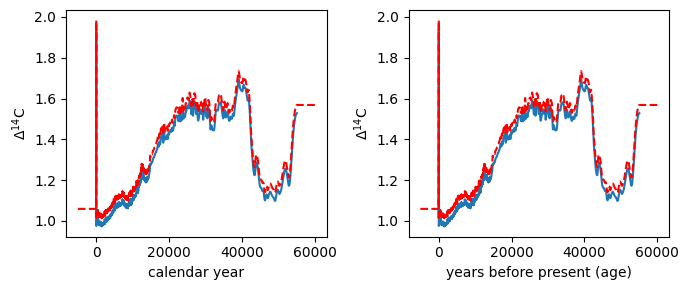

In [2]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
x_new = np.linspace(C14_DATA.years_before_2000.min()-5000, C14_DATA.years_before_2000.max()+5000, 100000)
y_new = INTERP_R_14C(x_new)

plt.sca(axs[0])
plt.plot(C14_DATA.years_before_2000, C14_DATA.R_14C)
plt.plot((x_new), y_new + 0.04, color='r', linestyle='--')
plt.xlabel('calendar year')
plt.ylabel('$\Delta^{14}$C')

plt.sca(axs[1])
plt.plot(C14_DATA.years_before_2000, C14_DATA.R_14C)
plt.plot(x_new, y_new + 0.04, color='r', linestyle='--')
plt.xlabel('years before present (age)')
plt.ylabel('$\Delta^{14}$C')

plt.tight_layout()
plt.show()

In [3]:
pow_diskin = PowerLawDisKin(1, 1000)
T_int = pow_diskin.calc_mean_transit_time()
T_calc = pow_diskin.T
print('Calcualted transit time: ', T_calc)
print('Integrated transit time: ', T_int[0])

A_calc = pow_diskin.A
A_int = pow_diskin.calc_mean_age()
print('Calculated mean age: ', A_calc)
print('Integrated mean age: ', A_int[0])

Calcualted transit time:  6.337874070325488
Integrated transit time:  6.337874070325485
Calculated mean age:  156.7816139771682
Integrated mean age:  156.7816139771682


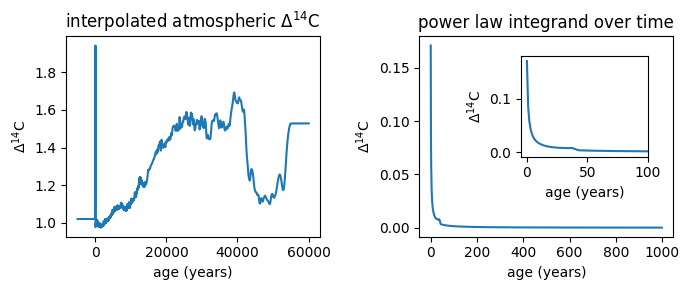

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

xs = np.arange(0, 1000, 1)
integrand = [pow_diskin.radiocarbon_age_integrand(x) for x in xs]

plt.sca(axs[0])
plt.plot(x_new, INTERP_R_14C(x_new), label='14C')
plt.ylabel('$\Delta^{14}$C')
plt.xlabel('age (years)')
plt.title('interpolated atmospheric $\Delta^{14}$C')

plt.sca(axs[1])
plt.plot(xs, integrand, label='integrand')
plt.ylabel('$\Delta^{14}$C')
plt.xlabel('age (years)')
plt.title('power law integrand over time')

# Make an inset zooming in on the integrand for the first 100 years
axins = axs[1].inset_axes([0.4, 0.4, 0.5, 0.5])
axins.plot(xs, integrand)
axins.set_xlim(-5, 100)
axins.set_xlabel('age (years)')
axins.set_ylabel('$\Delta^{14}$C')

plt.tight_layout()
plt.show()

In [5]:
integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=10000)
               #epsabs=1e-5)


/var/folders/6f/_716m82x3n32hwr7x9h4fp2c0000gp/T/ipykernel_55378/899380971.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=10000)


(1.0949165120085484, 0.0005496215175884519)

In [6]:
# Build a grid of tau_0 and tau_inf values
tau_0s = np.linspace(0, 10, 50)
tau_infs = np.linspace(1e3, 1e5, 50)

TAU_0, TAU_INF = np.meshgrid(tau_0s, tau_infs)
R = np.zeros((len(tau_0s), len(tau_infs)))

# Calculate the radiocarbon age for each pair of tau_0 and tau_inf
# and store the result in the R matrix
for i, tau_0 in enumerate(tau_0s):
    for j, tau_inf in enumerate(tau_infs):
        pow_diskin = PowerLawDisKin(tau_0, tau_inf)
        res = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf)
        R[i, j] = res[0]

/Users/yinonmb/Weizmann Institute Dropbox/YinonMoise Bar-On/git/soil_diskin/notebooks/models.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  self.T = tau_0 * np.exp(self.tratio) * e1_term
/var/folders/6f/_716m82x3n32hwr7x9h4fp2c0000gp/T/ipykernel_55378/1049071507.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf)


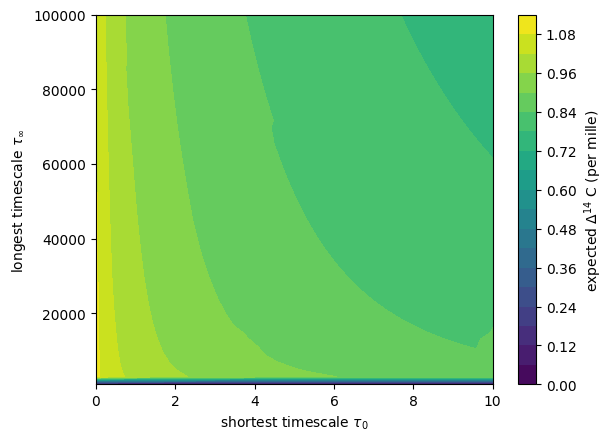

In [7]:
# contour plot with logarithmic color scale
plt.figure()
plt.contourf(TAU_0, TAU_INF, R, levels=20, cmap='viridis')
plt.colorbar().set_label('expected $\Delta^{14}$ C (per mille)')
plt.xlabel('shortest timescale $\\tau_0$')
plt.ylabel('longest timescale $\\tau_{\infty}$')
plt.show()

In [8]:
pow_diskin = PowerLawDisKin(2.4, 35000)
integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)

/var/folders/6f/_716m82x3n32hwr7x9h4fp2c0000gp/T/ipykernel_55378/3833458193.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)


(0.8914072248240142, 0.0010545063943249557)

In [9]:
pow_diskin = PowerLawDisKin(10, 80000)
integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)

/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_93700/2169476006.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)


(0.7775032279007507, 0.001138146489726816)

In [9]:
pow_diskin = PowerLawDisKin(1, 10000)
integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)

/var/folders/6f/_716m82x3n32hwr7x9h4fp2c0000gp/T/ipykernel_55378/1285367398.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)


(0.9944897560952274, 0.0009547975647078646)

In [11]:
pow_diskin.pA(1000)

0.00010469356777468416

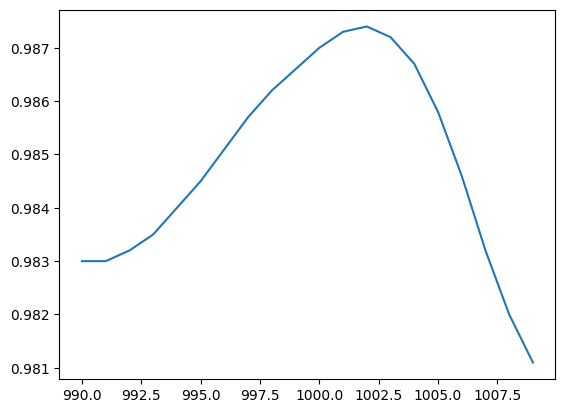

In [12]:
xs = np.arange(990, 1010, 1)
plt.plot(xs, INTERP_R_14C(xs))

In [ ]:
# Values calculated in Mathematica by Yinon Bar-On
ymb_check_vals = [
    {'tau_0': 1, 'tau_inf': 10000, 't': 1000, 'pA_expected': 0.000104694, 'R_14C_expected': 0.987,
     'R_hat_expected': 0.997303},
    {'tau_0': 2.4, 'tau_inf': 35000, 't': 1000, 'pA_expected': 0.00010759, 'R_14C_expected': 0.987,
     'R_hat_expected': 0.893637},
]

for check_vals in ymb_check_vals:
    tau_0 = check_vals['tau_0']
    tau_inf = check_vals['tau_inf']
    pow_diskin = PowerLawDisKin(tau_0, tau_inf)
    t = check_vals['t']
    pA = pow_diskin.pA(t)
    R_14C = INTERP_R_14C(t)
    R_hat = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)

    pA_exp = check_vals['pA_expected']
    pA_err = np.abs(pA - pA_exp)
    R_14C_exp = check_vals['R_14C_expected']
    R_14C_err = np.abs(R_14C - R_14C_exp)
    R_hat_exp = check_vals['R_hat_expected']
    R_hat_err = np.abs(R_hat[0] - R_hat_exp)

    print('tau_0: ', tau_0, 'tau_inf: ', tau_inf)
    print(f'pA({t}): {pA} expected: {pA_exp}; err = {pA_err}')
    print(f'R_14C({t}): {R_14C} expected: {R_14C_exp}; err = {R_14C_err}')
    print(f'R_hat: {R_hat[0]}, expected: {R_hat_exp}; err = {R_hat_err}')
    print('')

tau_0:  1 tau_inf:  10000
pA(1000): 0.00010469356777468416 expected: 0.000104694; err = 4.3222531584115147e-10
R_14C(1000): 0.987 expected: 0.987; err = 0.0
R_hat: 0.9944897560952274, expected: 0.997303; err = 0.0028132439047726665

tau_0:  2.4 tau_inf:  35000
pA(1000): 0.00010759013665357266 expected: 0.00010759; err = 1.366535726536524e-10
R_14C(1000): 0.987 expected: 0.987; err = 0.0
R_hat: 0.8914072248240141, expected: 0.893637; err = 0.002229775175985882



/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_93700/523414026.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  R_hat = integrate.quad(pow_diskin.radiocarbon_age_integrand, 0, np.inf, limit=100000)
